In [11]:
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
news = pd.read_csv("/Users/rhyscrooks/Desktop/Uni/4th_Year/Current Topics/fake_or_real_news.csv")
if 'Unnamed: 0' in news.columns: 
    news = news.drop(columns=['Unnamed: 0'])

In [13]:
news

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [14]:
news.info()

<class 'pandas.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   title   6335 non-null   str  
 1   text    6335 non-null   str  
 2   label   6335 non-null   str  
dtypes: str(3)
memory usage: 29.3 MB


No nulls so dont have to clean or remove anything

Create 3 models: 
- df1 = one with just title (can it predict real/fake from title alone)
- df2 = one with just text (can it predict real/fake from text alone)
- df3 = combined (can it predict real/fake from both title and text) 

In [15]:
fake_count = news[news['label'] == 'FAKE']['label'].count()
real_count = news[news['label'] == 'REAL']['label'].count()
print(f'Number of real articles: {real_count}\n' 
      f'Number of fake articles: {fake_count}\n')

Number of real articles: 3171
Number of fake articles: 3164



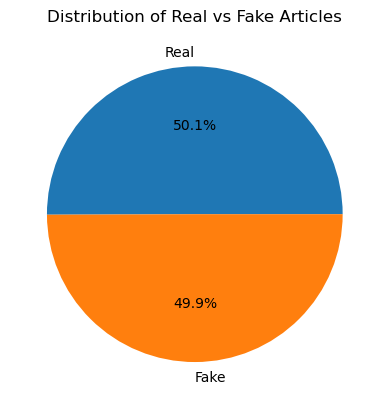

In [16]:
# visualisation of real vs fake articles 
labels = ["Real", "Fake"]
counts = [real_count, fake_count]

plt.figure()
plt.pie(counts, labels=labels, autopct="%1.1f%%")
plt.title("Distribution of Real vs Fake Articles")
plt.show()

In [17]:
news['label'] = news['label'].replace('FAKE', 'fake')
news['label'] = news['label'].replace('REAL', 'real')

In [18]:
df1 = news.copy() 
df2 = news.copy() 
df3 = news.copy()

## Preprocessing

In [19]:
# Normalisation function 

def normalise_text(text):
    text = str(text)
    text = text.lower() # convert to lower case
    text = re.sub(r'[^\w\s]', '', text) # remove special characters and punctuation
    text = text.strip() # strip whitespaces
    text = re.sub(r'\s+', ' ', text) # collapses multiple spaces
    
    return text

# Apply to specific columns
df1['title'] = df1['title'].apply(normalise_text) 
df2['text'] = df2['text'].apply(normalise_text)
df3['title'] = df1['title'].apply(normalise_text) 
df3['text'] = df2['text'].apply(normalise_text)

In [21]:
# lematisation 

import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatise(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df1['title'] = df1['title'].apply(lemmatise)
df2['text']  = df2['text'].apply(lemmatise)
df3['title'] = df3['title'].apply(lemmatise)
df3['text']  = df3['text'].apply(lemmatise)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rhyscrooks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Processing to vectors

In [26]:
# Converting to vectors 

from gensim.models import Word2Vec

df1_tokens = df1['title'].apply(lambda x: x.split())
df2_tokens = df2['text'].apply(lambda x: x.split())
df3_title_tokens = df3['title'].apply(lambda x: x.split())
df3_text_tokens = df3['text'].apply(lambda x: x.split())
df3_tokens = df3_title_tokens + df3_text_tokens

# Train Word2Vec model
model1 = Word2Vec(sentences=df1_tokens, vector_size=100, window=5, min_count=1, workers=4)
model2 = Word2Vec(sentences=df2_tokens, vector_size=100, window=5, min_count=1, workers=4)
model3 = Word2Vec(sentences=df3_tokens, vector_size=100, window=5, min_count=1, workers=4)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [27]:
# document level vecors 

def get_doc_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

df1['vector'] = df1_tokens.apply(lambda x: get_doc_vector(x, model1))
df2['vector'] = df2_tokens.apply(lambda x: get_doc_vector(x, model2))
df3['vector'] = df3_tokens.apply(lambda x: get_doc_vector(x, model3))

In [28]:
# ecoding labels 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df1['label_encoded'] = le.fit_transform(df1['label'])
df2['label_encoded'] = le.fit_transform(df2['label'])
df3['label_encoded'] = le.fit_transform(df3['label'])

## Modelling 

In [31]:
# splitting 
from sklearn.model_selection import train_test_split

# Convert vector columns to 2D arrays
X1 = np.stack(df1['vector'].values)
X2 = np.stack(df2['vector'].values)
X3 = np.stack(df3['vector'].values)

y1 = df1['label_encoded']
y2 = df2['label_encoded']
y3 = df3['label_encoded']

# Train/test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

### Logistic Regression

In [32]:
# modelling - logistic regression 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialise the model
lr = LogisticRegression(max_iter=1000)

# df1 - title only
lr.fit(X1_train, y1_train)
y1_pred = lr.predict(X1_test)
print("df1 (title only):")
print(classification_report(y1_test, y1_pred, target_names=['fake', 'real']))

# df2 - text only
lr.fit(X2_train, y2_train)
y2_pred = lr.predict(X2_test)
print("df2 (text only):")
print(classification_report(y2_test, y2_pred, target_names=['fake', 'real']))

# df3 - combined
lr.fit(X3_train, y3_train)
y3_pred = lr.predict(X3_test)
print("df3 (combined):")
print(classification_report(y3_test, y3_pred, target_names=['fake', 'real']))

df1 (title only):
              precision    recall  f1-score   support

        fake       0.57      0.58      0.57       628
        real       0.58      0.56      0.57       639

    accuracy                           0.57      1267
   macro avg       0.57      0.57      0.57      1267
weighted avg       0.57      0.57      0.57      1267

df2 (text only):
              precision    recall  f1-score   support

        fake       0.89      0.87      0.88       628
        real       0.87      0.89      0.88       639

    accuracy                           0.88      1267
   macro avg       0.88      0.88      0.88      1267
weighted avg       0.88      0.88      0.88      1267

df3 (combined):
              precision    recall  f1-score   support

        fake       0.89      0.88      0.89       628
        real       0.89      0.89      0.89       639

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89

#### Interpretation 

**Title Only**

Poor result with only 57% accuracy, which is only 7% better than guessing. This model and method is struggling with both classes (real/fake). From these results we can see that from the title alone it is difficult to classify between real and fake with accuracy. This could be due to the preprocessing steps that likely reduce the sensationalism generally seen within fake articles. 

**Text Only** 

A significant increase in performance identifying 88% percent of articles with a balanced performance across both classes. This is to be expected becuase 'text' encompasses far more linguistic signals that can distinguish fake and real news, such as writing style, sources cited, emotional language, and factual claims. This model catches 87% of fake articles and is right 89% of the time. 

**Combined** 

A marginal imporvement increasing by just 1% suggesting that infromation encoded within the title is worht 1%. The model is already extracting most of the useful signal from the body text alone.

### Random Forest 

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

# df1 - title only
rf.fit(X1_train, y1_train)
y1_pred_rf = rf.predict(X1_test)
print("df1 (title only):")
print(classification_report(y1_test, y1_pred_rf, target_names=['fake', 'real']))

# df2 - text only
rf.fit(X2_train, y2_train)
y2_pred_rf = rf.predict(X2_test)
print("df2 (text only):")
print(classification_report(y2_test, y2_pred_rf, target_names=['fake', 'real']))

# df3 - combined
rf.fit(X3_train, y3_train)
y3_pred_rf = rf.predict(X3_test)
print("df3 (combined):")
print(classification_report(y3_test, y3_pred_rf, target_names=['fake', 'real']))

df1 (title only):
              precision    recall  f1-score   support

        fake       0.62      0.65      0.63       628
        real       0.64      0.60      0.62       639

    accuracy                           0.63      1267
   macro avg       0.63      0.63      0.63      1267
weighted avg       0.63      0.63      0.63      1267

df2 (text only):
              precision    recall  f1-score   support

        fake       0.88      0.91      0.89       628
        real       0.91      0.87      0.89       639

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89      0.89      0.89      1267

df3 (combined):
              precision    recall  f1-score   support

        fake       0.87      0.90      0.89       628
        real       0.90      0.87      0.88       639

    accuracy                           0.88      1267
   macro avg       0.89      0.88      0.88      1267
weighted avg       0.89

#### Interpretation 

**Title Only** 

An improvement compared to logistic regression model (63%) suggesting a random forest model is better at indetifying fake articles from the title alone. However it is still a poor score overall, supporting previous results which indicate title alone is an unreliable varaible. 

**Text Only** 

Matches Logistic Regression's performance on text. Interestingly the model is slightly better at catching fake articles (recall 0.91) than real ones (recall 0.87), meaning it's slightly more aggressive at flagging things as fake. This could be a concern in a real world system where you don't want to incorrectly flag real news as fake.

**Combined** 

Surprisingly, the combined model performs slightly worse than text only (88% vs 89%). This is unusual and suggests that adding the title is actually introducing a little noise rather than helping. Random Forest may be getting confused by the extra title features that weren't useful in title only

### SVM 

In [34]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', random_state=42)

# df1 - title only
svm.fit(X1_train, y1_train)
y1_pred_svm = svm.predict(X1_test)
print("df1 (title only):")
print(classification_report(y1_test, y1_pred_svm, target_names=['fake', 'real']))

# df2 - text only
svm.fit(X2_train, y2_train)
y2_pred_svm = svm.predict(X2_test)
print("df2 (text only):")
print(classification_report(y2_test, y2_pred_svm, target_names=['fake', 'real']))

# df3 - combined
svm.fit(X3_train, y3_train)
y3_pred_svm = svm.predict(X3_test)
print("df3 (combined):")
print(classification_report(y3_test, y3_pred_svm, target_names=['fake', 'real']))

df1 (title only):
              precision    recall  f1-score   support

        fake       0.57      0.52      0.54       628
        real       0.57      0.62      0.59       639

    accuracy                           0.57      1267
   macro avg       0.57      0.57      0.57      1267
weighted avg       0.57      0.57      0.57      1267

df2 (text only):
              precision    recall  f1-score   support

        fake       0.90      0.88      0.89       628
        real       0.88      0.90      0.89       639

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89      0.89      0.89      1267

df3 (combined):
              precision    recall  f1-score   support

        fake       0.89      0.89      0.89       628
        real       0.89      0.89      0.89       639

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89

#### Interpretation 

**Title Only** 

Same as Logistic Regression and worse than Random Forest on titles. Interestingly there's a slight imbalance — the model is better at catching real articles (recall 0.62) than fake ones (recall 0.52), meaning it's slightly biased towards predicting real. Again this confirms titles alone are not sufficient regardless of model.

**Text Only** 

Strong performance, matching Random Forest and just edging Logistic Regression. Notably the precision for fake is 0.90 — the highest fake precision across all three models — meaning SVM is the most trustworthy when it flags something as fake.

**Combined** 

A perfectly balanced result with every single metric is 0.89 across both classes. This is the most consistent performance of any model on any dataframe, suggesting SVM handles the combined features the most cleanly. Going forward this will be the chosen model and inputs due to the reliability

## Improvments 

### Finding Optimal Parameters 

In [35]:
from sklearn.model_selection import GridSearchCV

params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
grid = GridSearchCV(SVC(random_state=42), params, cv=5, scoring='accuracy')
grid.fit(X3_train, y3_train)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

Best params: {'C': 100, 'kernel': 'rbf'}
Best score: 0.905687599665882


In [36]:
best_svm = grid.best_estimator_

y3_pred_best = best_svm.predict(X3_test)
print(classification_report(y3_test, y3_pred_best, target_names=['fake', 'real']))

              precision    recall  f1-score   support

        fake       0.92      0.91      0.91       628
        real       0.91      0.92      0.92       639

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



#### Interpretation 

Adjusting the parameters of the svm model increased the accuracy by 2% which is meaningful given the dataset size. With a cross validation score of 90.5% and test score of 91% indicates the model has generalised well to unseen data and is not overfitting. Furthermore precision and recall are almost identical across both classes (91%/92%), meaning the model isn't biased towards predicting fake or real. It's equally good at catching both which is ideal.

### Word2Vec Optimisation 

In [43]:
# Increase vector size from 100 to 300
model3 = Word2Vec(sentences=df3_tokens, vector_size=300, window=10, min_count=1, workers=4)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [42]:
df3['vector'] = df3_tokens.apply(lambda x: get_doc_vector(x, model3))

X3 = np.stack(df3['vector'].values)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)


best_svm = SVC(kernel='rbf', C=100, random_state=42)
best_svm.fit(X3_train, y3_train)
y3_pred = best_svm.predict(X3_test)
print(classification_report(y3_test, y3_pred, target_names=['fake', 'real']))

              precision    recall  f1-score   support

        fake       0.92      0.91      0.91       628
        real       0.91      0.92      0.92       639

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



#### Interpretation

The tuned SVM model with 300-dimensional Word2Vec vectors achieved an overall accuracy of 91% on the test set of 1,267 articles. The model performed consistently across both classes, achieving an F1-score of 0.91 for fake articles and 0.92 for real articles, indicating no significant bias towards either class. In terms of precision, the model correctly identified 92% of articles it predicted as fake and 91% of articles it predicted as real. Recall was similarly strong, with the model successfully catching 91% of all truly fake articles and 92% of all truly real articles. The near identical macro and weighted averages of 0.91 across all metrics further confirm the model's balanced performance, which is particularly important in a fake news detection context where both missing fake articles and incorrectly flagging real ones carry real world consequences.

In [45]:
# increasing vector size to 350 
model3 = Word2Vec(sentences=df3_tokens, vector_size=350, window=10, min_count=1, workers=4)
df3['vector'] = df3_tokens.apply(lambda x: get_doc_vector(x, model3))

X3 = np.stack(df3['vector'].values)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)


best_svm = SVC(kernel='rbf', C=100, random_state=42)
best_svm.fit(X3_train, y3_train)
y3_pred = best_svm.predict(X3_test)
print(classification_report(y3_test, y3_pred, target_names=['fake', 'real']))

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


              precision    recall  f1-score   support

        fake       0.90      0.91      0.91       628
        real       0.91      0.90      0.91       639

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



#### Interpretation 

A marginal decrease in performance indicating a dimension size of 300 perfroms better compared to 350

### Removing stopwords 

In [49]:
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatise(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

df3['title'] = df3['title'].apply(lemmatise)
df3['text']  = df3['text'].apply(lemmatise)

df3_title_tokens = df3['title'].apply(lambda x: x.split())
df3_text_tokens = df3['text'].apply(lambda x: x.split())
df3_tokens = df3_title_tokens + df3_text_tokens

# Train Word2Vec model
model3 = Word2Vec(sentences=df3_tokens, vector_size=300, window=5, min_count=1, workers=4)

df3['vector'] = df3_tokens.apply(lambda x: get_doc_vector(x, model3))

X3 = np.stack(df3['vector'].values)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)


best_svm = SVC(kernel='rbf', C=100, random_state=42)
best_svm.fit(X3_train, y3_train)
y3_pred = best_svm.predict(X3_test)
print(classification_report(y3_test, y3_pred, target_names=['fake', 'real']))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rhyscrooks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rhyscrooks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


              precision    recall  f1-score   support

        fake       0.92      0.91      0.91       628
        real       0.91      0.92      0.91       639

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



#### Interpretation 

A slight drop in perfromance when removing stopwords. This suggests words like "the", "is", "and" actually help and improve the model

## Summary 

This project aimed to build a fake news detector using a dataset of 6,335 news articles, equally split between fake and real. Three versions of the dataset were created with title only (df1), text only (df2), and combined title and text (df3). This enabled me to investigate which features were most useful for classification. Text was preprocessed through normalisation and lemmatisation before being converted to numerical vectors using Word2Vec.

Three classifiers were evaluated; Logistic Regression, Random Forest, and SVM. Title only models performed poorly across all classifiers, peaking at 63% with Random Forest, suggesting article headlines alone do not contain enough information to reliably detect fake news. Text only and combined models performed significantly better, with most achieving around 88-89% accuracy.

The best performing model was a tuned SVM using RBF kernel with C=100, trained on 300-dimensional Word2Vec vectors of the combined title and text features, achieving 91% accuracy with balanced precision and recall across both classes. Hyperparameter tuning via GridSearchCV and increasing Word2Vec vector size from 100 to 300 dimensions were the two most impactful improvements. Stopword removal and increasing vector size beyond 300 dimensions both slightly decreased performance, suggesting the model had reached its optimal configuration.